In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import s2_selection_utility as ssu

Start import
Working on midway2-0412.rcc.local with the following versions 
and installation paths:
strax
	v0.13.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.14.4	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [81]:
dsets = st.select_runs(exclude_tags='messy', run_mode='tpc_commissioning*',
                       available=('event_basics','peak_basics'))
#dsets = dsets[(dsets.end > pd.to_datetime('01/25/2021'))] # earliest run
#dsets = dsets[(dsets.end < pd.to_datetime('01/25/2021'))] # 
print('total number of runs:', len(dsets))

total number of runs: 464


In [82]:
dsets.head(20)

,name,number,mode,start,end,tags,livetime,peak_basics_available,raw_records_available,event_basics_available
3,012089,12089,tpc_commissioning,2021-01-26 08:06:16.004,2021-01-26 09:06:18.017,,0 days 01:00:02.013000,True,False,True
4,012088,12088,tpc_commissioning,2021-01-26 07:05:55.779,2021-01-26 08:05:58.768,,0 days 01:00:02.989000,True,False,True
8,012084,12084,tpc_commissioning,2021-01-26 06:05:40.199,2021-01-26 07:05:41.485,,0 days 01:00:01.286000,True,False,True
11,012081,12081,tpc_commissioning,2021-01-26 05:05:22.461,2021-01-26 06:05:22.858,,0 days 01:00:00.397000,True,False,True
14,012078,12078,tpc_commissioning,2021-01-26 04:05:02.203,2021-01-26 05:05:05.219,,0 days 01:00:03.016000,True,False,True
18,012074,12074,tpc_commissioning,2021-01-26 03:04:42.895,2021-01-26 04:04:44.964,,0 days 01:00:02.069000,True,False,True
21,012071,12071,tpc_commissioning,2021-01-26 02:04:25.231,2021-01-26 03:04:25.562,,0 days 01:00:00.331000,True,False,True
28,012064,12064,tpc_commissioning,2021-01-26 00:03:46.300,2021-01-26 01:03:47.988,,0 days 01:00:01.688000,True,False,True
31,012061,12061,tpc_commissioning,2021-01-25 23:03:31.275,2021-01-26 00:03:32.008,,0 days 01:00:00.733000,True,False,True
38,012054,12054,tpc_commissioning,2021-01-25 21:02:57.958,2021-01-25 22:02:58.953,,0 days 01:00:00.995000,True,False,True


In [23]:
def select_peaks_times(st, run_id, ndiv = 10, div = 0, s2_start = 0):
    events = st.get_array(run_id,'event_info')
    peaks = st.get_array(run_id,'peak_basics')
    area = []
    width = []
    areachn = []
    aft = []
    data = []
    s1_times = []
    s1_endtimes = []
    s2_times = []
    s2_endtimes = []
    drift_times = []
    r_data = pd.DataFrame(columns=['area','range_50p_area','area_per_channel','area_fraction_top','data',
                                  's1_time','s1_endtime','s2_time','s2_endtime','drift_time'])
    
    t_start = time.time()
    tsec = (peaks['endtime'][-1]-peaks['time'][0])/1e9
    csec = tsec/ndiv
    print('run',run_id,'Total events',len(events),'total peaks',len(peaks),'duration',tsec)
    k = s2_start
    
    #for i in range(nd):
    pp = st.get_array(run_id,['peaks','peak_basics'],
                  seconds_range=(csec*div,csec*(div+1)),progress_bar=False)
    nn = len(pp)
    dt = pp['dt'][0]
    dts = np.arange(0,pp['data'].shape[1]*dt,dt)
    ft = pp['endtime'][-1]
    for j in range(nn):
        t = pp['time'][j]
        if t >= ft or k == len(events): break
        elif events['s2_time'][k]==0:
            area.append(0)
            width.append(0)
            areachn.append(0)
            aft.append(0)
            data.append(0)
            s1_times.append(events['s1_time'][k])
            s1_endtimes.append(events['s1_endtime'][k])
            s2_times.append(events['s2_time'][k])
            s2_endtimes.append(events['s2_endtime'][k])
            drift_times.append(events['drift_time'][k])
            k += 1
        elif t == events['s2_time'][k] and k < len(events)-1:
            area.append(pp['area'][j])
            width.append(pp['range_50p_area'][j])
            areachn.append(pp['area_per_channel'][j])
            aft.append(pp['area_fraction_top'][j])
            data.append(pp['data'][j])
            s1_times.append(events['s1_time'][k])
            s1_endtimes.append(events['s1_endtime'][k])
            s2_times.append(events['s2_time'][k])
            s2_endtimes.append(events['s2_endtime'][k])
            drift_times.append(events['drift_time'][k])
            k += 1
    diff = time.time() - t_start
    print(f'division n. {div}, tot. events {nn}, selected {len(area)}, tot.sel. {k} time to process {diff:.2f} s')
    del pp
    r_data['area'] = area
    r_data['range_50p_area'] = width
    r_data['area_per_channel'] = areachn
    r_data['area_fraction_top'] = aft
    r_data['data'] = data
    r_data['s1_time'] = s1_times
    r_data['s1_endtime'] = s1_endtimes
    r_data['s2_time'] = s2_times
    r_data['s2_endtime'] = s2_endtimes
    r_data['drift_time'] = drift_times
    r_data.to_hdf(f'data/select_peaks_run{run_id}_div{div}.h5', key='df', mode='w')
    return r_data, k

In [24]:
run_id = '011673'
div = 0
#pdata, k0 = select_peaks_times(st, run_id, peaks, events, 10, div, 0)
pdata = pd.read_hdf(f'data/select_peaks_run{run_id}_div{div}.h5')

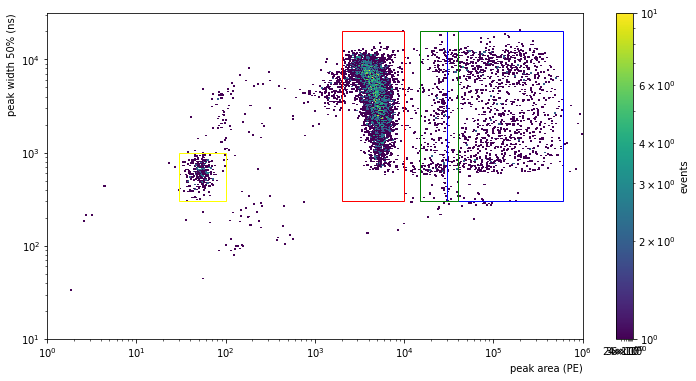

In [25]:
psu.plot_area_width(pdata,low=0,high=6,low2=1,high2=4.5,binning=500)
width_all = (0,1e6)
area0 = (30,100)
area1 = (2e3,1e4)
area2 = (3e4,6e5)
area3 = (1.5e4,4e4)
width0 = (300,1000)
width1 = (300,2e4)
width2 = (300,2e4)
width3 = (300,2e4)
psu.rectangle(area0, width0, 'yellow')
psu.rectangle(area1, width1, 'r')
psu.rectangle(area2, width2, 'b')
psu.rectangle(area3, width3, 'g')

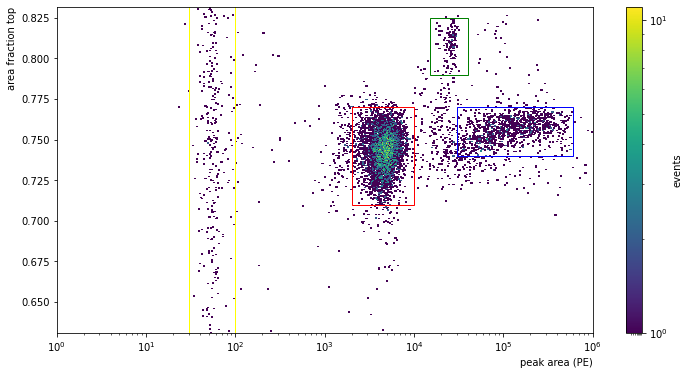

In [26]:
psu.plot_area_top(pdata,low=0,high=6,low2=-0.2,high2=-0.08,binning=500)
aft1 = (0.71,0.77)
aft2 = (0.74,0.77)
aft3 = (0.79,0.825)
psu.rectangle(area0, (0,1), 'yellow')
psu.rectangle(area1, aft1, 'r')
psu.rectangle(area2, aft2, 'b')
psu.rectangle(area3, aft3, 'g')

In [27]:
def plotwf(peaks,nn,area_cut,width_cut,aft_cut=(0,1),color='b'):
    peaks=peaks[(peaks['area']<area_cut[1])&(peaks['area']>area_cut[0])&
                (peaks['range_50p_area']<width_cut[1]) &
                (peaks['range_50p_area']>width_cut[0]) &
                (peaks['area_fraction_top']>aft_cut[0]) &
                (peaks['area_fraction_top']<aft_cut[1])]
    nev = len(peaks['data'])
    print('total number of events',nev)
    fig, axs = plt.subplots(nn,figsize=(12,8))
    for i in range(nn):
        idx = np.array(peaks.index)[i]
        dts = np.arange(0,len(peaks['data'][idx])*10,10)
        axs[i].plot(dts,peaks['data'][idx],drawstyle='steps',color=color)
        axs[i].set_xlabel("time (ns)", ha='right', x=1)
        axs[i].set_ylabel(f"PE", ha='right', y=1)

total number of events 341
total number of events 5660
total number of events 1106
total number of events 119


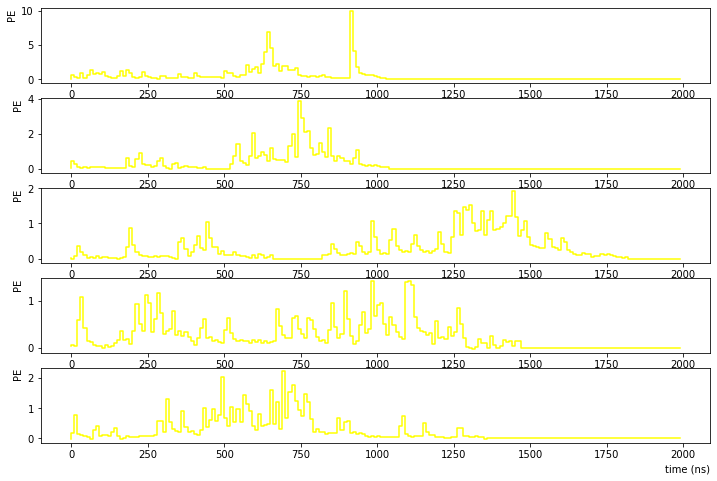

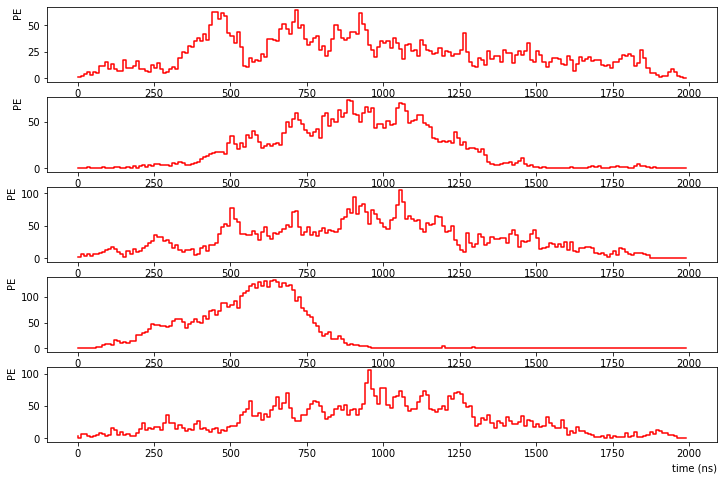

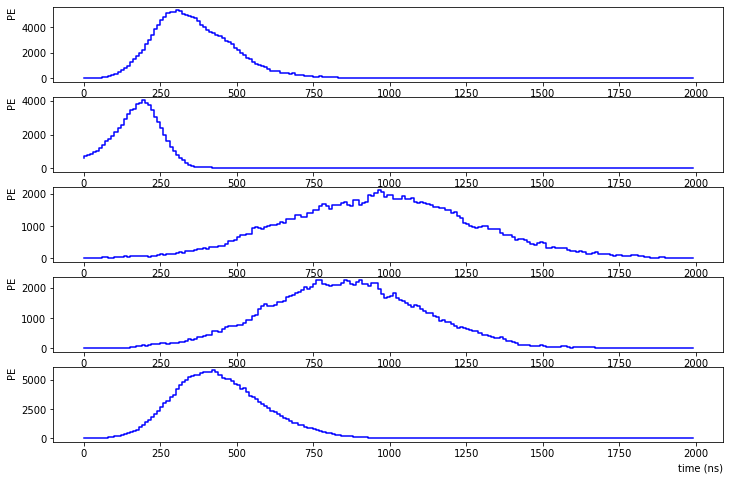

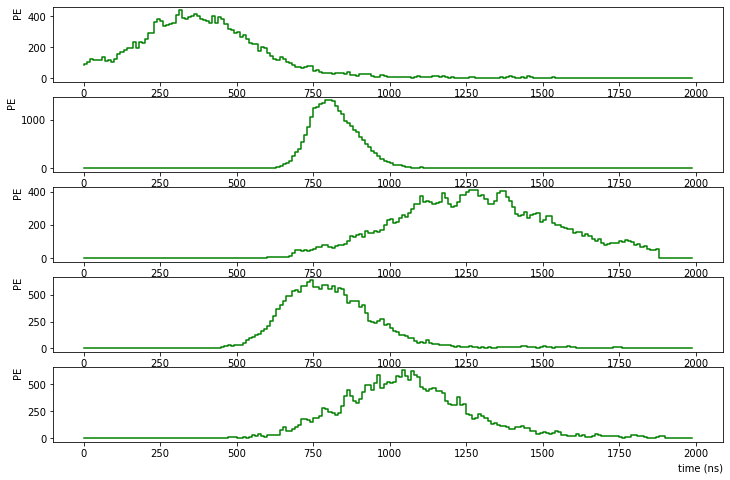

In [28]:
plotwf(pdata,5,area0,width0, (0,1), 'yellow')
plotwf(pdata,5,area1,width1,aft1,'r')
plotwf(pdata,5,area2,width2,aft2,'b')
plotwf(pdata,5,area3,width3,aft3,'g')

In [29]:
def drifttime_vs_width(run_id, area_bounds, aft_bounds, width_bounds, rname, vd = 600):
    events = st.get_array(run_id,'event_info')

    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2500, 200)
    ph = Histdd(data_cut['drift_time']/1e3, data_cut['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id} - Region {rname}',fontsize=14)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

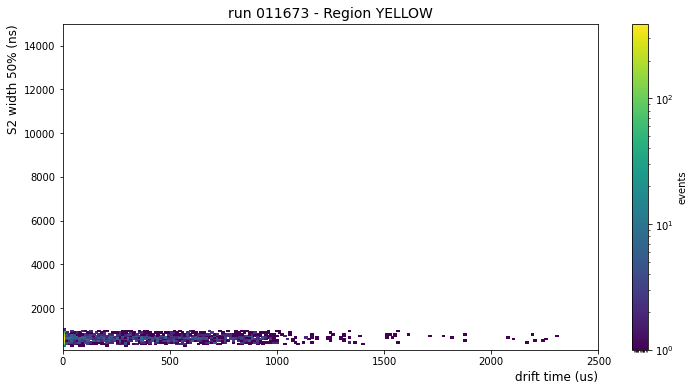

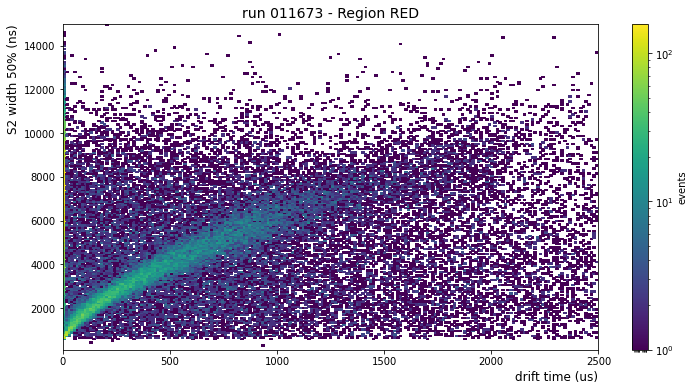

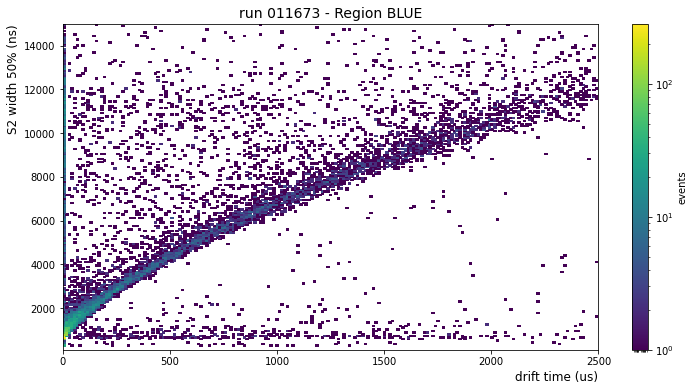

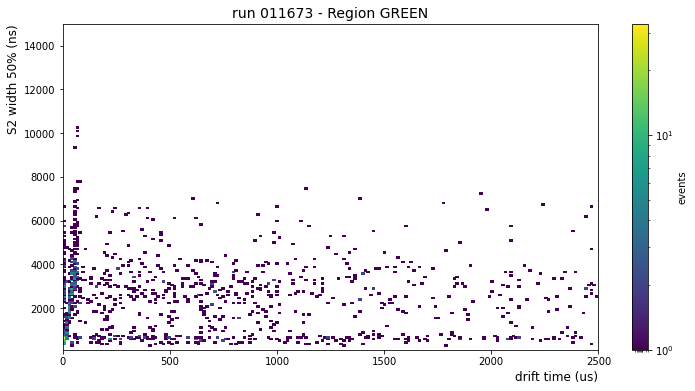

In [30]:
drifttime_vs_width(run_id, area0, (0,1), width0,'YELLOW')
drifttime_vs_width(run_id, area1, aft1, width1,'RED')
drifttime_vs_width(run_id, area2, aft2, width2,'BLUE')
drifttime_vs_width(run_id, area3, aft3, width3,'GREEN')

In [57]:
def diffusion_model(t, D, vd, w0):
    sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)        
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)
#def diffusionmodel(xp, tm, t0, maxdt):
#    return (t0**2 + (tm**2-t0**2) / maxdt *xp)**0.5

In [78]:
def diffusion_constant(run_id, area_bounds, aft_bounds, width_bounds, rname, fit_range, vd = 600):
    events = st.get_array(run_id,'event_info')

    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2500, 200)
    ph = Histdd(data_cut['drift_time']/1e3, data_cut['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id} - Region {rname}',fontsize=14)
    
    #mean = np.array(ph.average(axis=1))
    #plt.plot(t[:len(mean)], mean, color='r',linestyle='-', label='mean per drift time slice')
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    plt.plot(t[:len(perc50)], perc50, color='b',linestyle='--', label='50% percentile')
    
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    print(f'Drift velocity = {vd:.2f} m/s ')
    vd = vd * units.m / units.s
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = diffusion_model(t, *guess)
    #plt.plot(t, ys_m, c='yellow',linestyle='--',label='initial guess')
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: diffusion_model(x, D, vd, w0)
    #popt, pcov = curve_fit(diffusion, t[ll:hh], mean[ll:hh], p0=(D_guess, w0_guess))
    popt, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    ys_u = diffusion(t, *popt) + 1000
    ys_m = diffusion(t, *popt)
    ys_d = diffusion(t, *popt) - 1000

    plt.plot(t, ys_m, label=f'$D = {popt[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
    plt.plot(t, ys_u,color='r')
    plt.plot(t, ys_d,color='r')
    plt.legend(fontsize=14)
    #print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} +/- {perr[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'w0 = {popt[1]/(units.ns):.2f} +/- {perr[1]/(units.ns):.2f} ns ')
    
    plt.figure(figsize=(12,6))
    data = events[(events['s2_range_50p_area'] > diffusion(events['drift_time']/1e3, *popt)-1000) &
                  (events['s2_range_50p_area'] < diffusion(events['drift_time']/1e3, *popt)+1000)]
    phh = Histdd(data['drift_time']/1e3, data['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    phh.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id} - Region {rname}',fontsize=14)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 600.00 m/s 
Diffusion constant = 33.97 cm^2/s 
w0 = 491.94 +/- 117.76 ns 


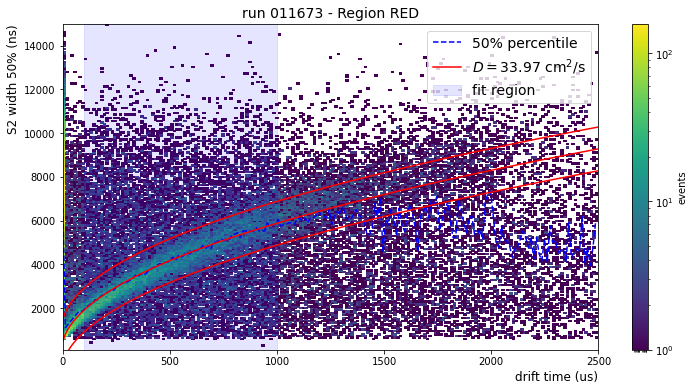

<Figure size 864x432 with 0 Axes>

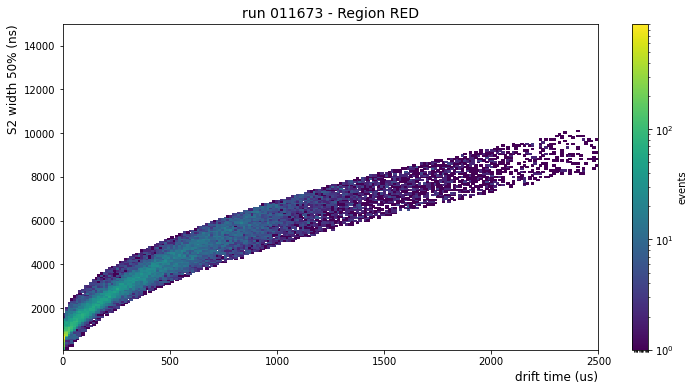

In [79]:
diffusion_constant('011673', area1, aft1, width1,'RED',fit_range=(100,1000))

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 600.00 m/s 
Diffusion constant = 50.26 cm^2/s 
w0 = 0.05 +/- inf ns 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


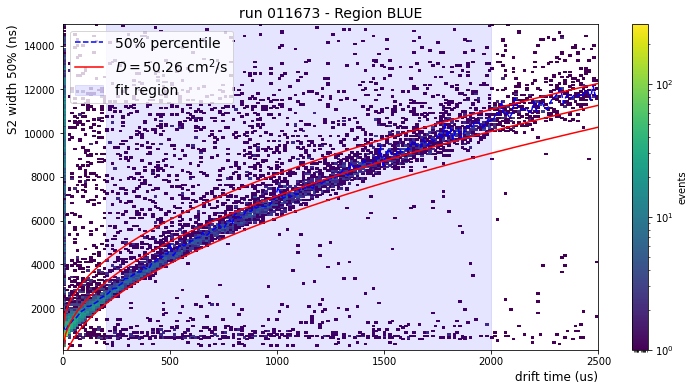

<Figure size 864x432 with 0 Axes>

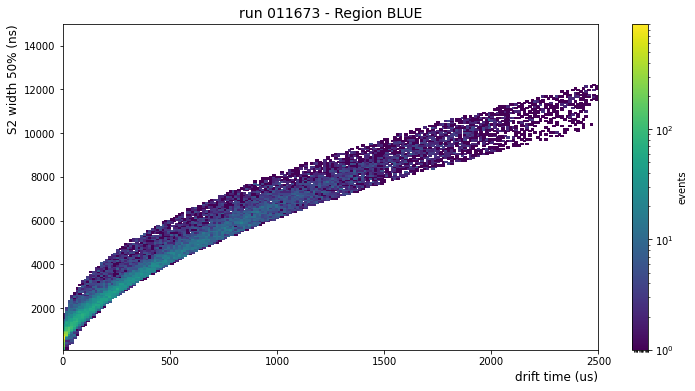

In [80]:
diffusion_constant('011673', area2, aft2, width2,'BLUE',fit_range=(200,2000))

In [18]:
def plot_tpc_position(run_id, area_bounds, aft_bounds, width_bounds, rname):
    events = st.get_array(run_id,'event_info')
    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    plt.figure(figsize=(12,12))
    plt.hist2d(data_cut['s2_x'],data_cut['s2_y'], range = [[-70,70],[-70,70]], bins = (200), cmin = 1, norm = LogNorm())
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'run {run_id} - Region {rname}',fontsize=14)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

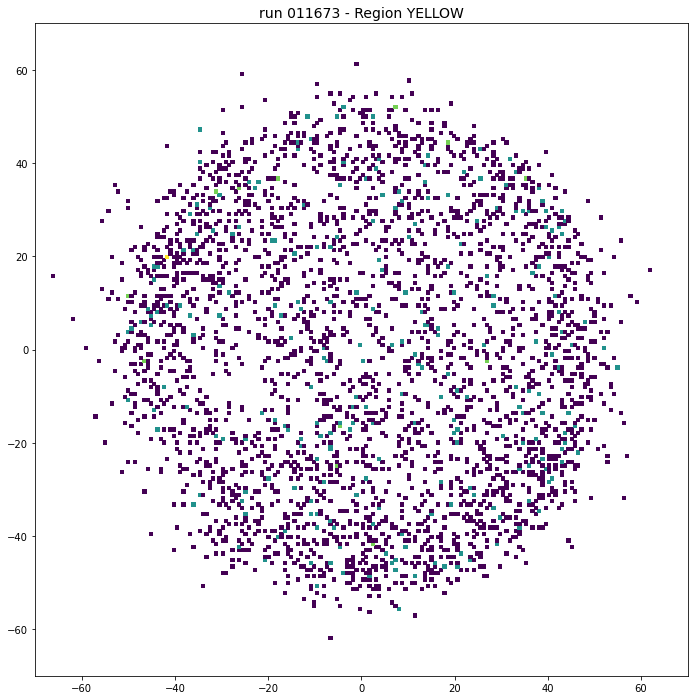

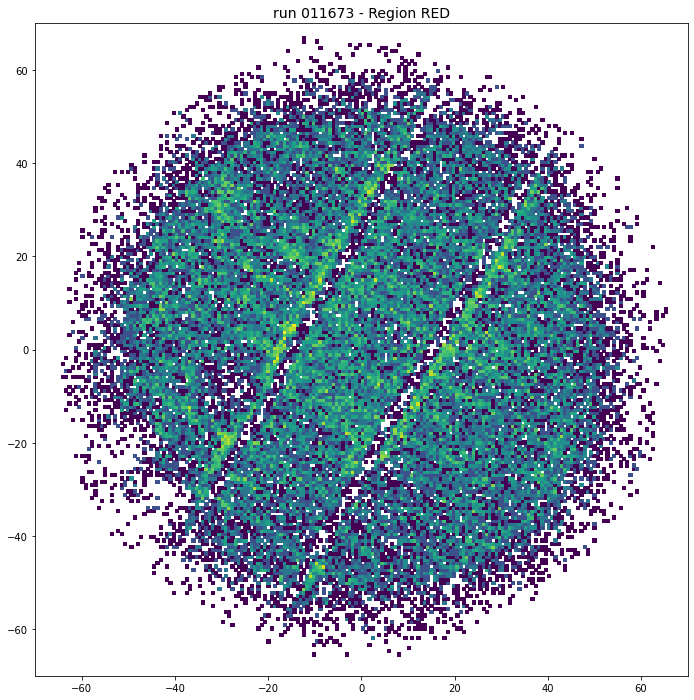

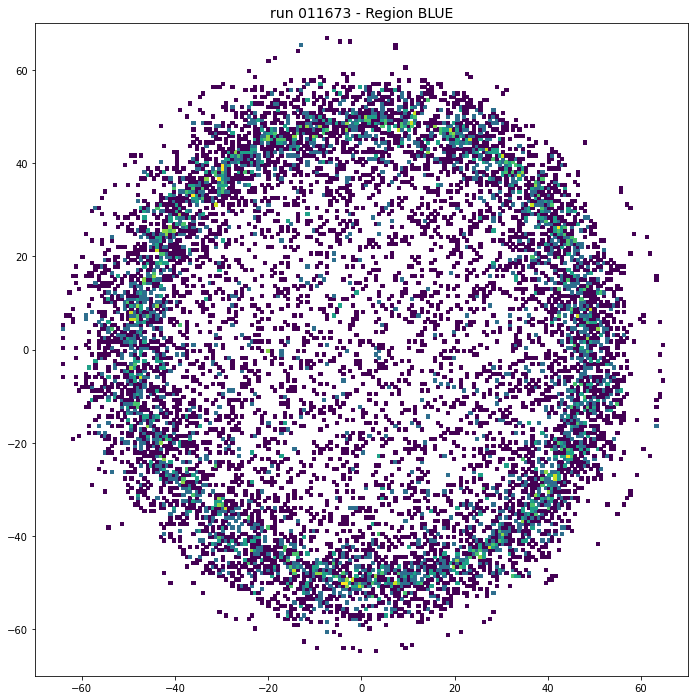

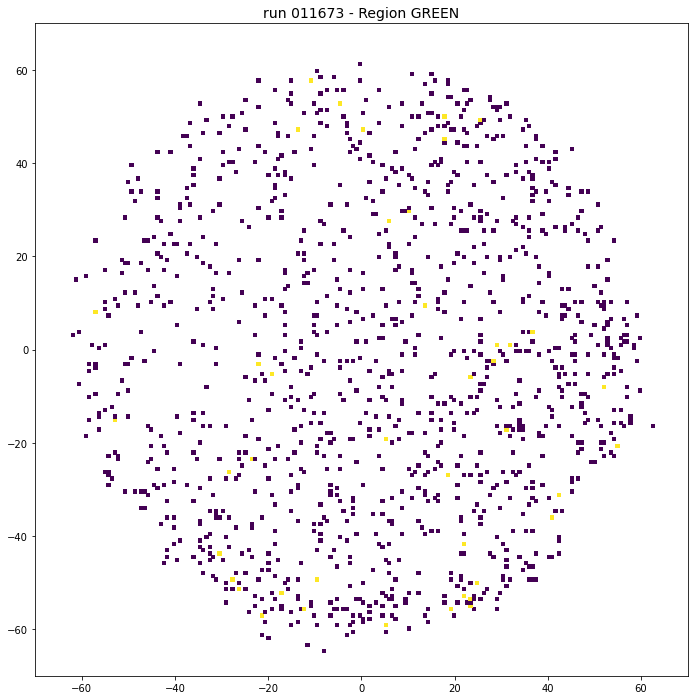

In [19]:
plot_tpc_position(run_id, area0, (0,1), width0,'YELLOW')
plot_tpc_position(run_id, area1, aft1, width1,'RED')
plot_tpc_position(run_id, area2, aft2, width2,'BLUE')
plot_tpc_position(run_id, area3, aft3, width3,'GREEN')

In [21]:
def plot_drift_time_aft(run_id, area_bounds, aft_bounds, width_bounds, rname, low = 0, high = 6000,
                        low2 = 0, high2 = 1, binning = 500):
    events = st.get_array(run_id,'event_info')
    events = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    
    x = np.linspace(low, high, binning)
    pha1 = Histdd(events['drift_time']/1e3, events['s1_area_fraction_top'],
                bins=(x, np.linspace(low2, high2, binning)))
    pha2 = Histdd(events['drift_time']/1e3, events['s2_area_fraction_top'],
                bins=(x, np.linspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    pha1.plot(log_scale=True, cblabel='events')
    
    plt.plot(x, 0.54-2.1*x/1e4,color='r',linestyle='-')#,label='$0.54-2.1\cdot10^{-4} drifttime$')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S1 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

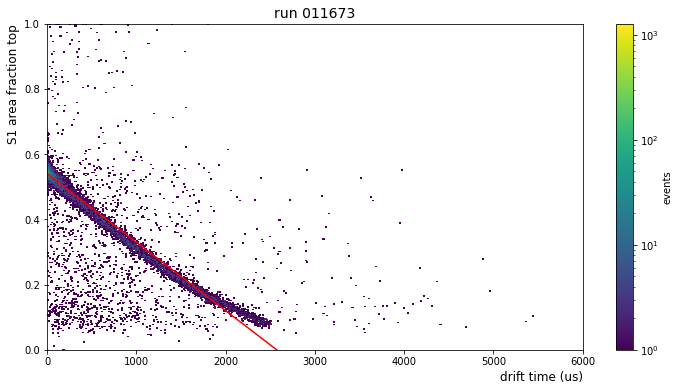

In [22]:
plot_drift_time_aft('011673', area2, aft2, width2,'BLUE')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

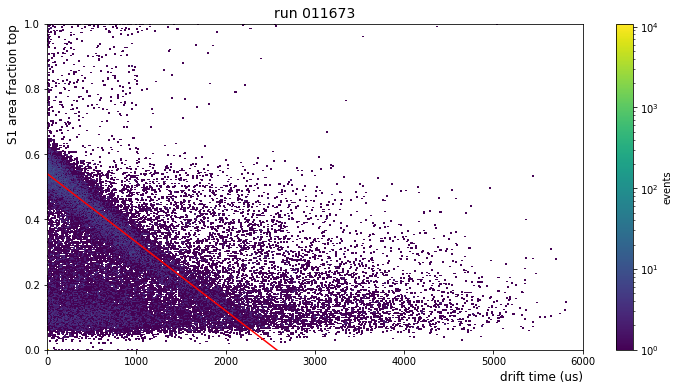

In [23]:
plot_drift_time_aft('011673', area1, aft1, width1,'RED')